In [1]:
import numpy as np
import matplotlib
import sys, platform, os
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import camb
from scipy.interpolate import interp1d

from camb import model, initialpower
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, interact, fixed
from scipy.signal import convolve

from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook  # Use an alias to avoid conflicts


import sys
sys.path.append('/home/rguidetti')
from PolAngle import *
from beam import * 
from map import *
from convolution import * 
from beam_class import *
from PatchFunctions import *  # nuove funzioni in quanto quelle vecchie lavoravano con mappe NxN. Queste funzionano per mappe rettangolari Nx,Ny

import lmfit 

# Power Spectra

In [2]:
# Read the PS originated from the Common_notebook
#Original_PS = np.loadtxt('Original_PS_001.txt')

In [3]:
#TT_ps  = Original_PS[0]
#TE_ps  = Original_PS[1]
#EE_ps  = Original_PS[2]
#BB_ps  = Original_PS[3]
#BB_ps_tensor  = Original_PS[4]

In [4]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0.001)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
pars.WantTensors= True

#calculate results for these parameters
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

totCL = powers['total']
unlensedCL = powers['unlensed_scalar']
tensor = powers['tensor']
print(totCL.shape)

ls = np.arange(totCL.shape[0])

# rinomino per comodità
TT_ps  = totCL[:,0] 
TE_ps  = totCL[:,3] 
EE_ps  = totCL[:,1] 
BB_ps  = totCL[:,2]
BB_ps_tensor  = tensor[:,2]

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential
(2551, 4)


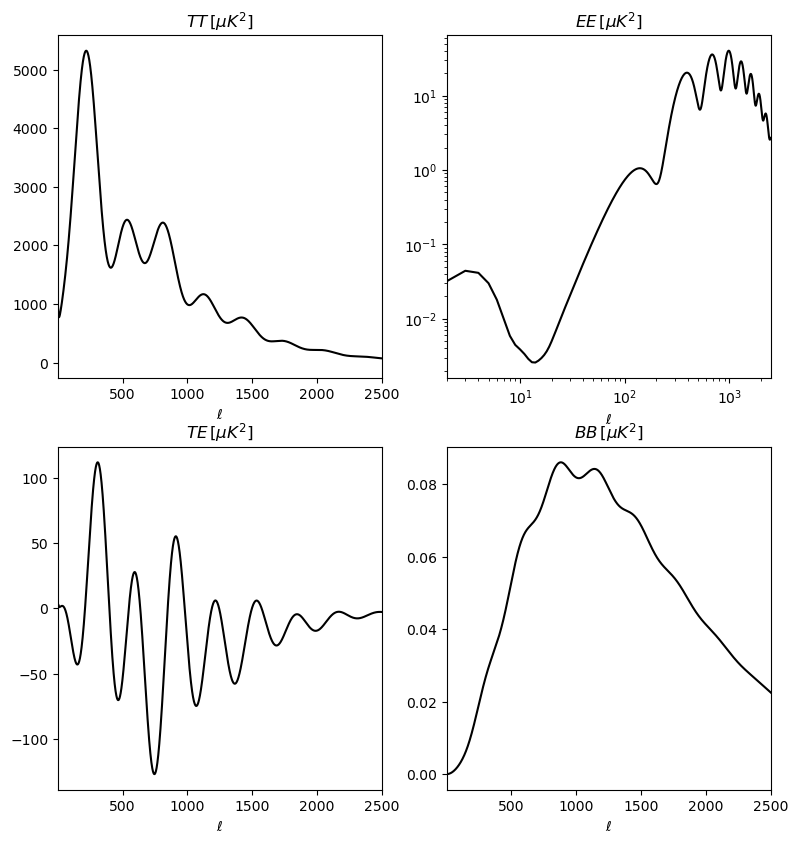

In [5]:
#plot the total CMB power spectra

ls = np.arange(TT_ps.shape[0])
fig, ax = plt.subplots(2,2, figsize = (9.2,9.8))

# TT
ax[0,0].plot(ls,TT_ps, color='k')
ax[0,0].set_title(r'$TT\, [\mu K^2]$')

#TE
ax[1,0].plot(ls,TE_ps, color='k')
ax[1,0].set_title(r'$TE\, [\mu K^2]$')

#EE
ax[0,1].loglog(ls,EE_ps, color='k')
ax[0,1].set_title(r'$EE\, [\mu K^2]$')
#ax[0,1].legend()

# BB
ax[1,1].plot(ls,BB_ps, color='k')
ax[1,1].set_title(r'$BB\, [\mu K^2]$')

for ax in ax.reshape(-1): 
    ax.set_xlim([2,2500])
    ax.set_xlabel(r'$\ell$')

# Maps

In [6]:
# MAP PARAMETERS

pix_size         = 0.5                              #arcmin
N                = 2**10                            #num pixel lineare
X_width, Y_width = N*pix_size/60., N*pix_size/60.   #dimensioni mappa in gradi
Nsqdeg           = X_width**2

c_min, c_max     = -200, 200                        #color map


# If I want to start from a given map dimension instead of number and size of pixels I do:
#N = (X_width * 60)/ pix_size #pixel number

print(f"Map with {N} x {N} pixels, each of {pix_size} arcmin, for a total dimension of {X_width:.2f} x {Y_width:.2f} gradi")


nbig = 5000

Map with 1024 x 1024 pixels, each of 0.5 arcmin, for a total dimension of 8.53 x 8.53 gradi


In [7]:
# ORIGINAL MAPS

ell_big = np.arange(nbig)

TT_ps_big = np.zeros(nbig)
TT_ps_big[ls.astype(int)] = TT_ps

EE_ps_big = np.zeros(nbig)
EE_ps_big[ls.astype(int)] = EE_ps

BB_ps_big = np.zeros(nbig)
BB_ps_big[ls.astype(int)] = BB_ps

TE_ps_big = np.zeros(nbig)
TE_ps_big[ls.astype(int)] = TE_ps

ell    = ell_big
ps_TT  = TT_ps_big + 1e-3   
ps_EE  = EE_ps_big + 1e-3
ps_BB  = BB_ps_big + 1e-3
ps_TE  = TE_ps_big

Temp_point_source_spectrum = ps_TT[1000]*(ell/3000.)**2.
Pol_point_source_spectrum  = ps_EE[1500]*(ell/4500.)**2.

ps_TT = ps_TT + Temp_point_source_spectrum  
ps_EE = ps_EE + Pol_point_source_spectrum
ps_BB = ps_BB + Pol_point_source_spectrum



T_map, Q_map, U_map, E_map, B_map = make_CMB_maps(N,pix_size,ell,ps_TT,ps_EE,ps_TE,ps_BB)

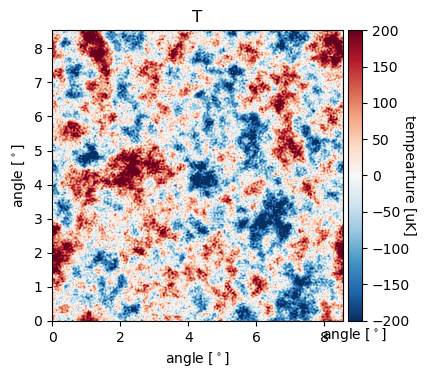

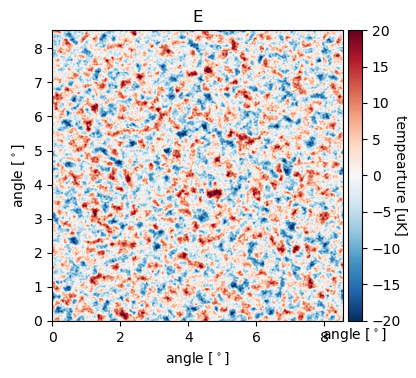

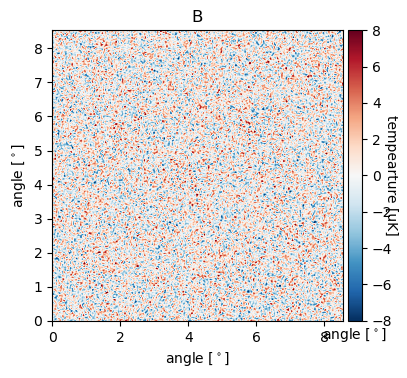

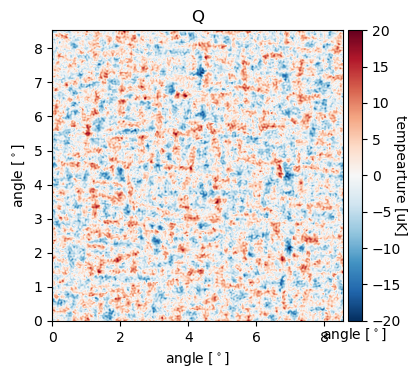

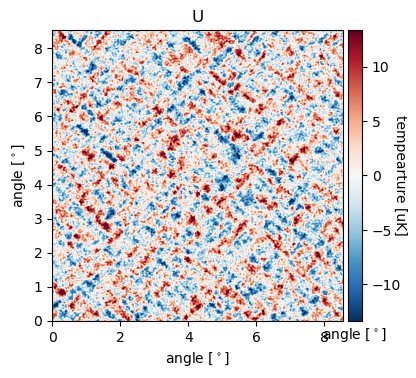

In [8]:
# PLOT ORIGINAL MAPS

plt.title("T")
plt.ylabel('angle $[^\circ]$')
plt.xlabel('angle $[^\circ]$')
p = Plot_CMB_Map(T_map,c_min,c_max,X_width,Y_width)

plt.title("E")
plt.ylabel('angle $[^\circ]$')
plt.xlabel('angle $[^\circ]$')
p = Plot_CMB_Map(E_map,c_min/10.,c_max/10.,X_width,Y_width)

plt.title("B")
plt.ylabel('angle $[^\circ]$')
plt.xlabel('angle $[^\circ]$')
p = Plot_CMB_Map(B_map,c_min/25,c_max/25,X_width,Y_width)

plt.title("Q")
plt.ylabel('angle $[^\circ]$')
plt.xlabel('angle $[^\circ]$')
p = Plot_CMB_Map(Q_map ,c_min/10.,c_max/10.,X_width,Y_width)

plt.title("U")
plt.ylabel('angle $[^\circ]$')
plt.xlabel('angle $[^\circ]$')
p = Plot_CMB_Map(U_map,c_min/15.,c_max/15.,X_width,Y_width)

## Beam + rings
Simulation of a realistic beam with a gaussian center peak and secondary peaks
https://github.com/McMahonCosmologyGroup/cmbInstrumentSummerSchool/blob/main/Notebook2_beam_systematics.ipynb

In [9]:
# COORDINATES LIKE THE ONES OF THE MAPS

Nx = int(N)
Ny = int(N)

onesx = np.ones(N)
onesy = np.ones(N)

indsx = (np.arange(Nx)+.5 - N/2.) * pix_size
indsy = (np.arange(Ny)+.5 - N/2.) * pix_size

X = np.outer(onesy, indsx)
Y = np.outer(indsy, onesx)
R = np.sqrt(X**2. + Y**2.)


#####################################################################################

array_dB  = np.array([-20, -24, -28, -32])
print("Peaks = ", array_dB)
    

# VARIABLES
FWHM_x = 4  # degrees
FWHM_y = 5  # degrees

    
ellipticity = (FWHM_x - FWHM_y) / (FWHM_x + FWHM_y)
print("ellipticity = ", ellipticity)


r1 = np.array([20, 50, 90, 130]) #angular distance of the peaks, degree
r = 2 # width of the rings

theta = 0 # angle of rotation of the beam
a = 1 # major axis of ellipses 


#########################################################################################

# BEAM

beam_x = {}

beam_x_gauss, beam_y_gauss, sec_rings_x, sec_rings_y, beam_x, beam_y = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, theta, array_dB, r, r1, X, Y, a, ellipticity)



Peaks =  [-20 -24 -28 -32]
ellipticity =  -0.1111111111111111


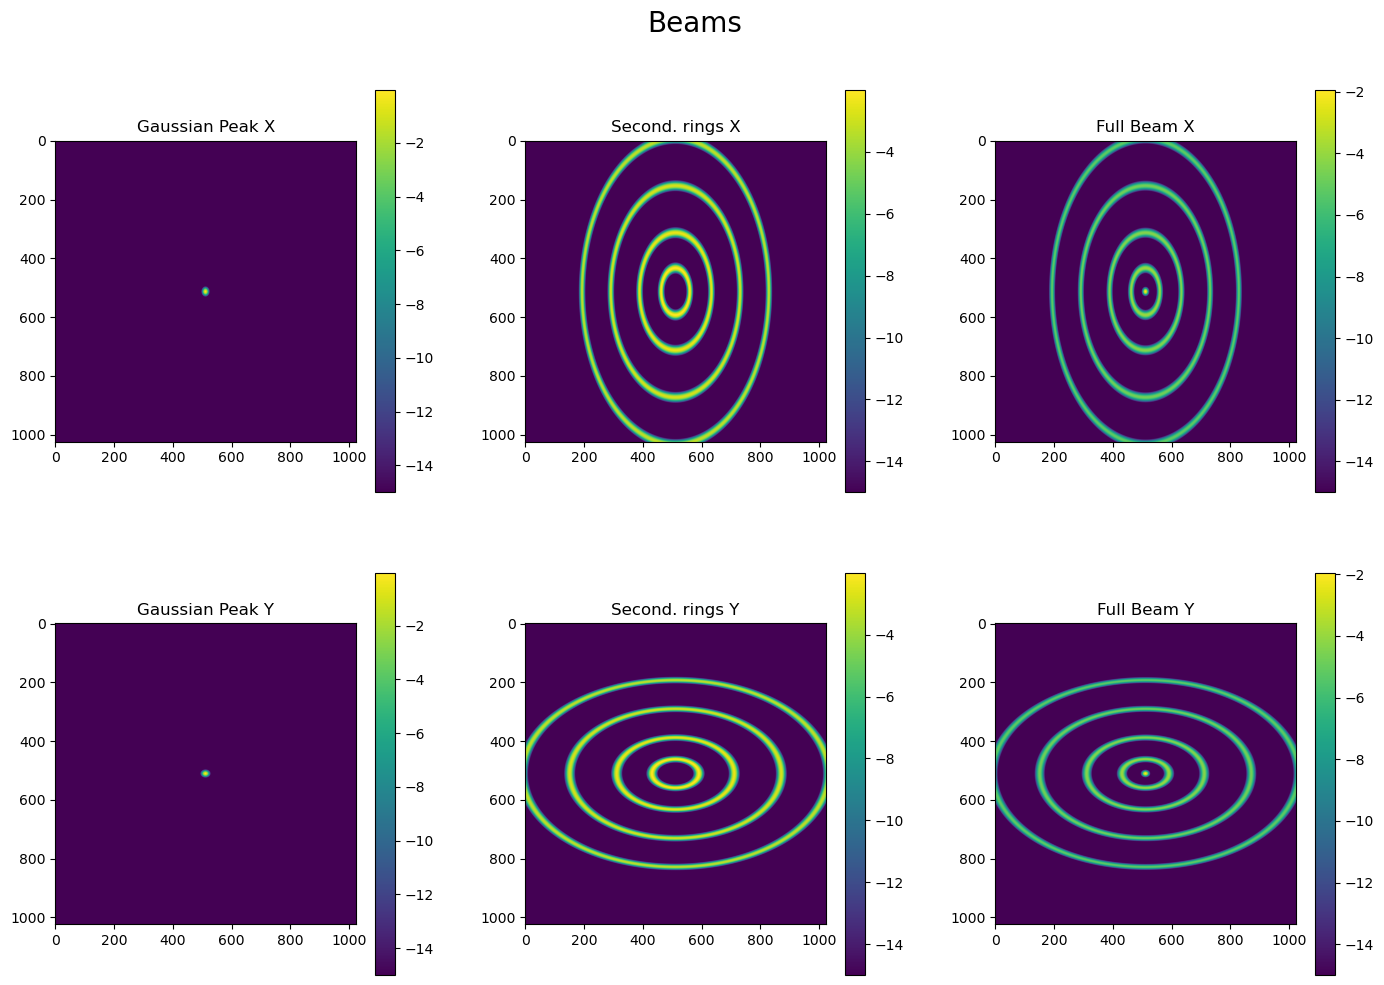

In [10]:
Map_to_Plot = [beam_x_gauss, sec_rings_x, beam_x, 
               beam_y_gauss, sec_rings_y, beam_y]
title = ["Gaussian Peak X","Second. rings X", "Full Beam X", 
         "Gaussian Peak Y","Second. rings Y", "Full Beam Y"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4]), np.max(Map_to_Plot[5])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4]), np.min(Map_to_Plot[5])]


fig, axs = plt.subplots(2, 3, figsize=(14, 10))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
    im = axs[i].imshow(np.log10(map_data+1e-15))
    axs[i].set_title(title[i])
    plt.colorbar(im, ax=axs[i], orientation='vertical')
    
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle(f'Beams', fontsize=20)
plt.show()

## Beam systematics
I will use beam_x for the convolution, so I add beam systematics to beam_x only

In [11]:
### beam systematics dictionary
bs = {"budy":{"A":1e-3,"FWHP":1.5,"R":50.,"psi":0.3,"polfracQ":0.5,"polfracU":0.01},  
                                                                         # little budy amplitude, 
                                                                         #FWHP, offset spacing, rotationa angle (radians)
                                                                        # pol_fraction for Q and U
     "ghostshelf": {"A":1e-10,"Diam":10.,"roll_off":7.},    #model of ghosting, amplitude (A), diameter (Diam) 
     "hex_crostalk":{"grid_space": 3.5,"N":5,"neighbor_exp_fall":0.01}, 
                                                                               ## model of optical cross talk 
                                                                               ## to detectors on a hex grid
                                                                               ## assumed to be exponetial
                                                                               ## assumed to be 50% polarized
      "TtoQ":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
      "TtoU":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
                                                                  ## multiplole expansion leakage
      'psi':0.01*np.pi/180.
                                  ## detetor angle rotations
                   }

In [12]:
beam_sys = BeamSystematics()
beam_TT, beam_QQ, beam_UU, beam_QT, beam_UT, beam_QU, beam_UQ = beam_sys.make_systematics_beams(N, pix_size, FWHM_x, beam_x, bs)

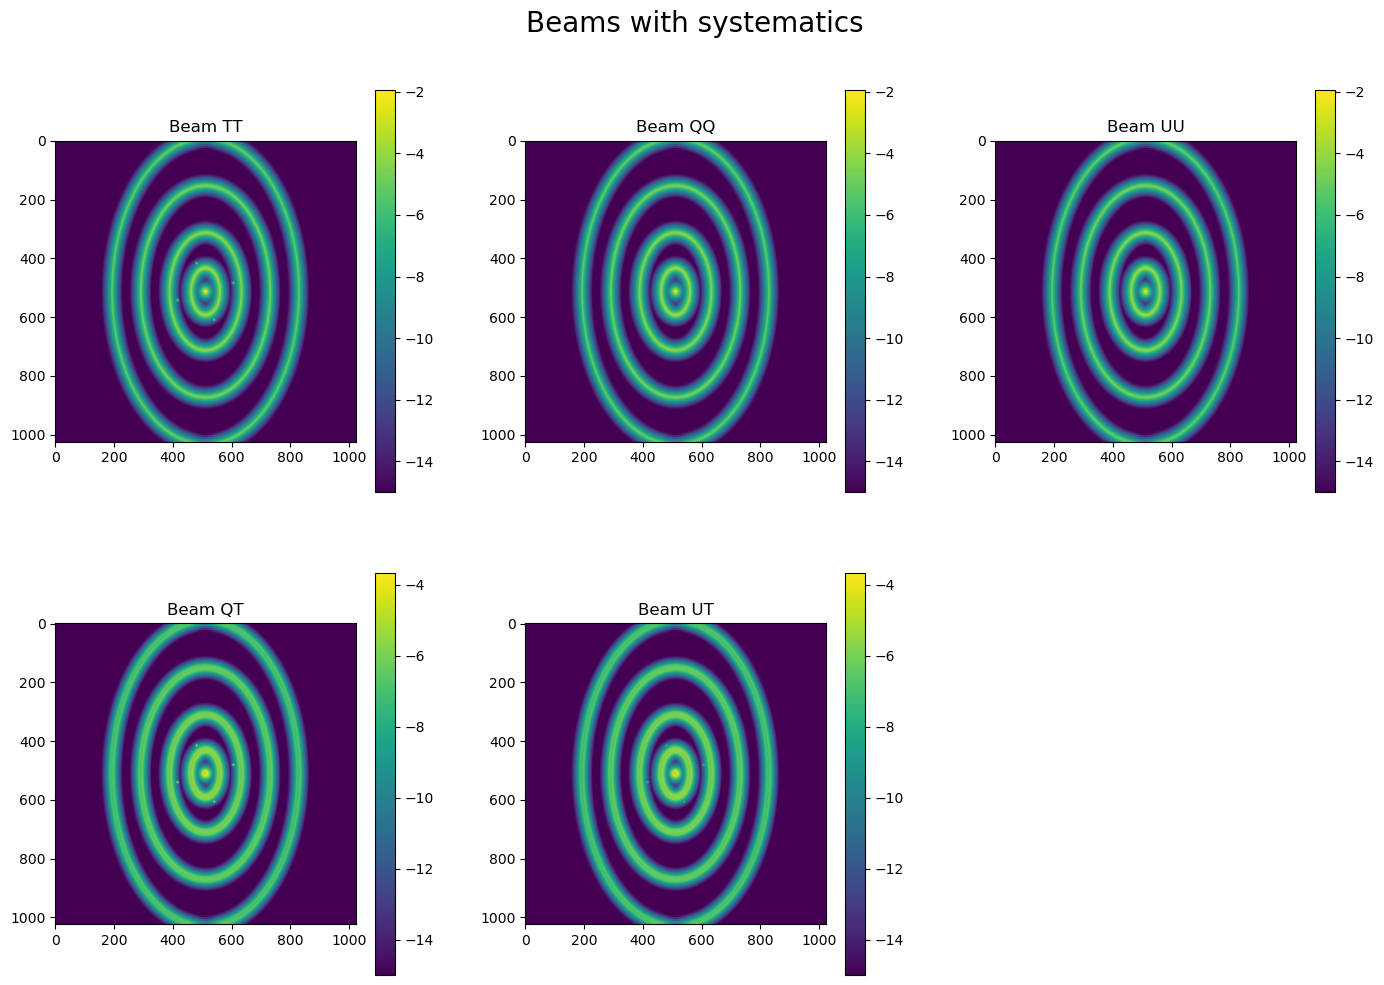

In [13]:
Map_to_Plot = [beam_TT, beam_QQ, beam_UU, beam_QT, beam_UT]
title = ["Beam TT", "Beam QQ", "Beam UU", "Beam QT", "Beam UT" ]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4])]


fig, axs = plt.subplots(2, 3, figsize=(14, 10))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
    im = axs[i].imshow(np.log10(map_data+1e-15))
    axs[i].set_title(title[i])
    plt.colorbar(im, ax=axs[i], orientation='vertical')
    
fig.delaxes(axs[-1])
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle(f'Beams with systematics', fontsize=20)
plt.show()

## Convolve the beam with the maps

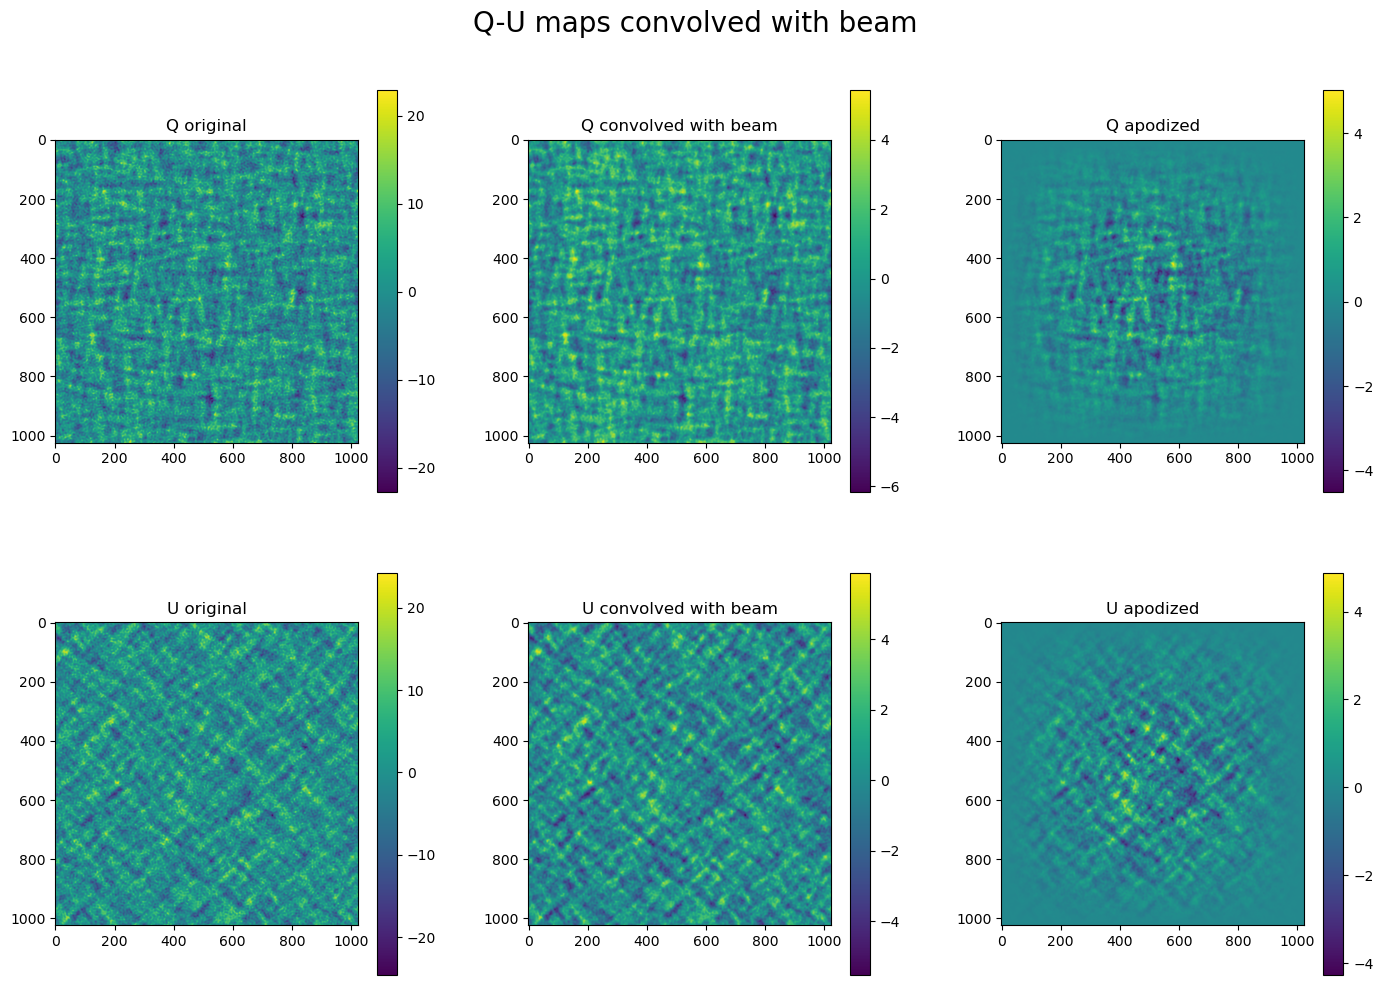

'\n# plot\nMap_to_Plot = [Q_conv_perf, Q_conv_real,Q_conv_ap, U_conv_perf, U_conv_real ,U_conv_ap]\ntitle = ["Q original","Q convolved","Q conv + ap", "U original","U convolved", "U conv + ap"]\nc_factor = [25, 25, 25,25, 25,25]\n\nfig, axs = plt.subplots(2, 3, figsize=(18, 10))\naxs      = axs.flatten()\nfor i, (map_data, c_factor_iter) in enumerate(zip(Map_to_Plot, c_factor)):\n        Plot_CMB_Map_compact(axs[i], map_data, c_min/c_factor_iter, c_max/c_factor_iter, X_width, Y_width)\n        axs[i].set_title(title[i])\n\nplt.tight_layout()\nplt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)\nplt.suptitle(\'Maps convolution with beam\', fontsize=20)\nplt.savefig(\'/Users/guide/Documents/University/TESI/immagini/BeamMapConvolution.png\')\nplt.show()\n'

In [14]:
## MAPS IN THE REAL SPACE

# convolution with perfect beam
perf_beam, no1, no2, no3, no4, no5 = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, 0, array_dB, r, r1, X, Y, a, ellipticity)
perf_beam = perf_beam / np.sum(perf_beam)

Q_conv_perf = convolve_map_with_beam(Q_map, perf_beam)
U_conv_perf = convolve_map_with_beam(U_map, perf_beam)


# convolution with real beam
Q_conv_real = convolve_map_with_beam(Q_map, beam_QQ)
U_conv_real = convolve_map_with_beam(U_map, beam_UU)
#E_conv = QU2EB()

####################################################################################################################################################################################################

# apodization
window = (cosine_window(N))
Q_conv_ap = window * Q_conv_real
U_conv_ap = window * U_conv_real

####################################################################################################################################################################################################

Map_to_Plot = [Q_map, Q_conv_real, Q_conv_ap, 
               U_map, U_conv_real, U_conv_ap]
title = ["Q original", "Q convolved with beam", "Q apodized", 
         "U original", "U convolved with beam", "U apodized"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4]), np.max(Map_to_Plot[5])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4]), np.min(Map_to_Plot[5])]


fig, axs = plt.subplots(2, 3, figsize=(14, 10))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
    im = axs[i].imshow(map_data, vmin=c_factor_iter_min, vmax=c_factor_iter_max)
    axs[i].set_title(title[i])
    plt.colorbar(im, ax=axs[i], orientation='vertical')
    
#fig.delaxes(axs[-1])
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle(f'Q-U maps convolved with beam', fontsize=20)
plt.show()

'''
# plot
Map_to_Plot = [Q_conv_perf, Q_conv_real,Q_conv_ap, U_conv_perf, U_conv_real ,U_conv_ap]
title = ["Q original","Q convolved","Q conv + ap", "U original","U convolved", "U conv + ap"]
c_factor = [25, 25, 25,25, 25,25]

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs      = axs.flatten()
for i, (map_data, c_factor_iter) in enumerate(zip(Map_to_Plot, c_factor)):
        Plot_CMB_Map_compact(axs[i], map_data, c_min/c_factor_iter, c_max/c_factor_iter, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle('Maps convolution with beam', fontsize=20)
plt.savefig('/Users/guide/Documents/University/TESI/immagini/BeamMapConvolution.png')
plt.show()
'''

### Deconvolution

In [15]:
def deconvolve_map(convolved_map, real_beam, perfect_beam):
    from scipy.fft import fft2, ifft2

    convolved_map_fft = np.fft.fft2(np.fft.fftshift(convolved_map))
    real_beam_fft     =  np.fft.fft2(np.fft.fftshift(real_beam))
    real_beam_fft    += 1e-22
    perfect_beam_fft  =  np.fft.fft2(np.fft.fftshift(perfect_beam))

    deconvolved_fft = convolved_map_fft * (perfect_beam_fft/ real_beam_fft)

    deconvolved_map = np.fft.fftshift(np.real(np.fft.ifft2(deconvolved_fft)))


    return deconvolved_map

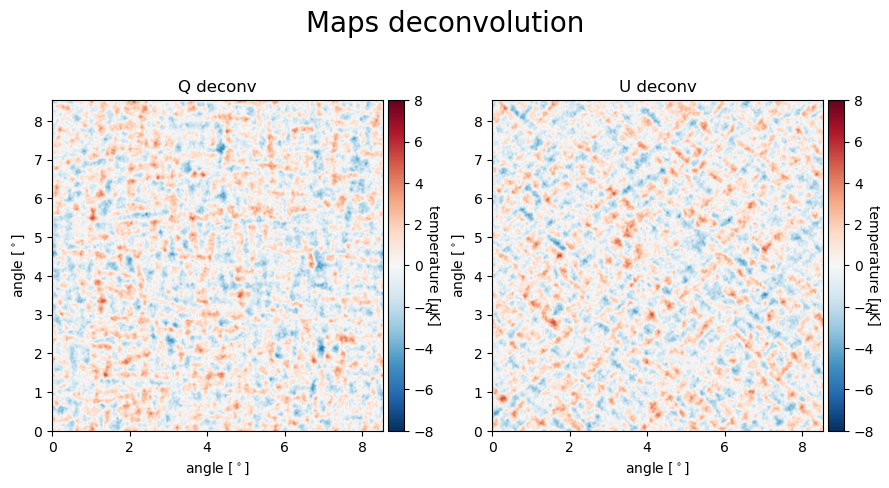

In [16]:
#Q_deconv = deconvolve_map(Q_conv_ap/window, beam_QQ, perf_beam)
#U_deconv = deconvolve_map(U_conv_ap/window, beam_UU, perf_beam)

Q_deconv = correct_lr(Q_conv_ap/window, perf_beam,N, pix_size, 'onestep', None, 1e-10, 1e-12, None, 50)
U_deconv = correct_lr(U_conv_ap/window, perf_beam,N, pix_size, 'onestep', None, 1e-10, 1e-12, None, 50)

Map_to_Plot = [Q_deconv, U_deconv]
title = ["Q deconv","U deconv"]
c_factor = [25, 25]

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs      = axs.flatten()
for i, (map_data, c_factor_iter) in enumerate(zip(Map_to_Plot, c_factor)):
        Plot_CMB_Map_compact(axs[i], map_data, c_min/c_factor_iter, c_max/c_factor_iter, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle('Maps deconvolution', fontsize=20)
plt.show()

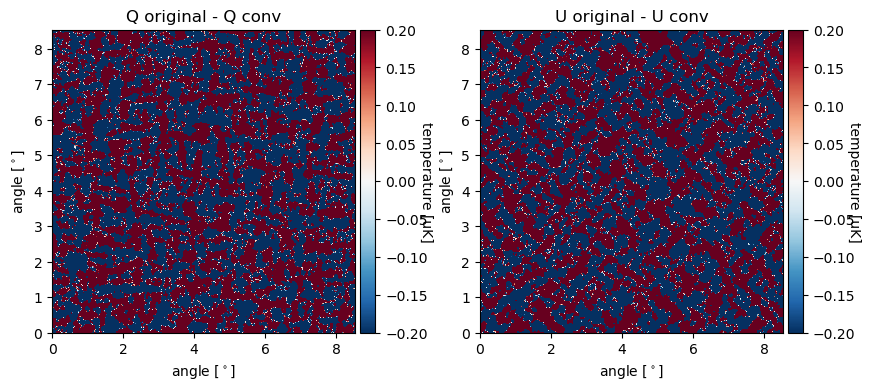

In [17]:
# DIFFERENCE
Q_diff = (Q_conv_perf- Q_deconv)
U_diff = (U_conv_perf- U_deconv)


#####################################################################
Map_to_Plot = [(Q_diff), (U_diff)]
title = ["Q original - Q conv","U original - U conv"]
c_factor = [1e3, 1e3]

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs      = axs.flatten()
for i, (map_data, c_factor_iter) in enumerate(zip(Map_to_Plot, c_factor)):
        Plot_CMB_Map_compact(axs[i], map_data, c_min/c_factor_iter, c_max/c_factor_iter, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
#plt.suptitle('Maps deconvolution', fontsize=20)
plt.show()

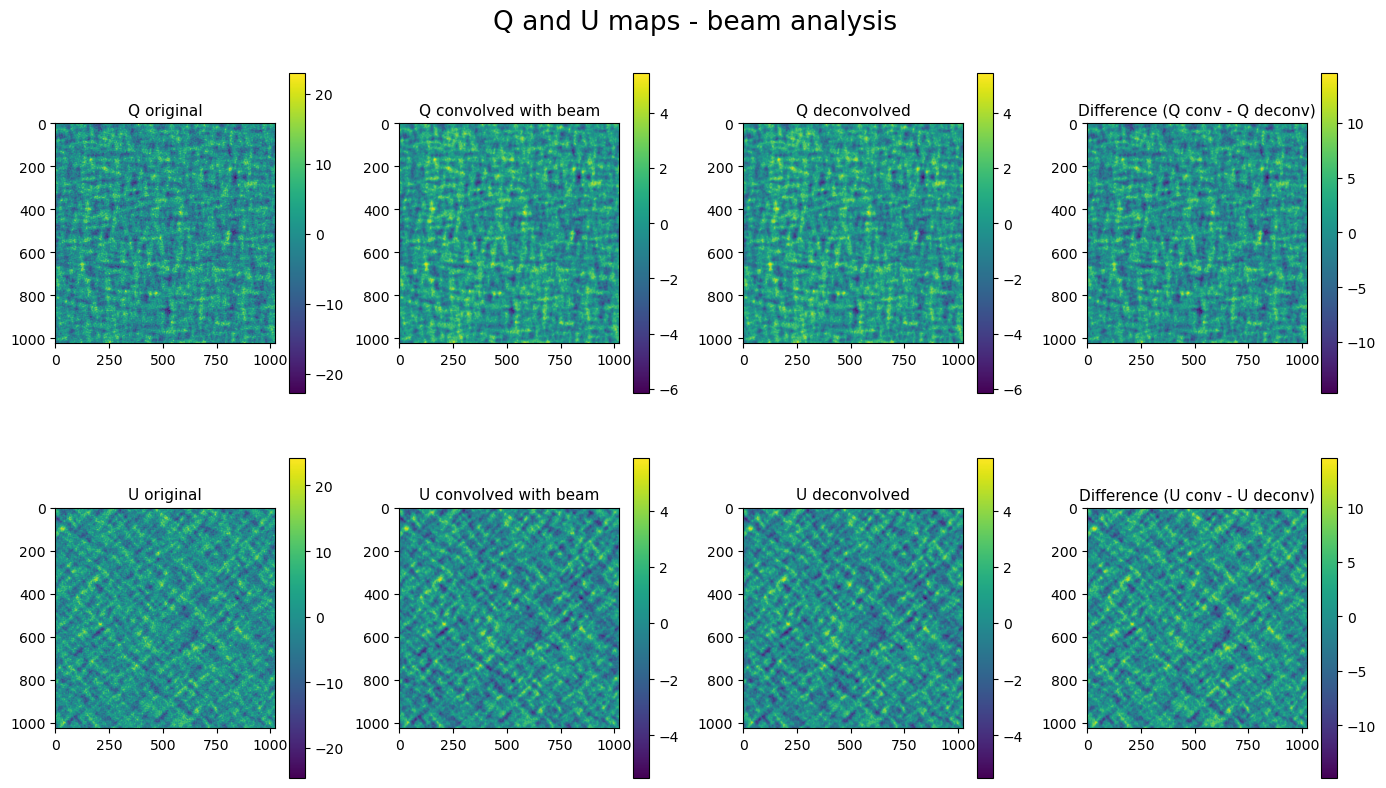

'\nMap_to_Plot = [Q_conv_perf, Q_conv_ap, Q_deconv, Q_diff, U_conv_perf ,U_conv_ap, U_deconv, U_diff]\ntitle = ["Q original","Q convolved + apodized","Q deconv", "Q deconv - Q original", "U original","U convolved + apodized", "U deconv", "U deconv - U original"]\nc_factor = [25, 25, 25, 1e3, 25, 25, 25, 1e3]\n\nfig, axs = plt.subplots(2, 4, figsize=(18, 10))\naxs      = axs.flatten()\nfor i, (map_data, c_factor_iter) in enumerate(zip(Map_to_Plot, c_factor)):\n        Plot_CMB_Map_compact(axs[i], map_data, c_min/c_factor_iter, c_max/c_factor_iter, X_width, Y_width)\n        axs[i].set_title(title[i])\n\nplt.tight_layout()\nplt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)\nplt.suptitle(\'Q and u maps- before and after conv-deconv\', fontsize=16)\nplt.savefig(\'/Users/guide/Documents/University/TESI/immagini/QU_ConvDeconv.png\')\nplt.show()\n'

In [18]:
# plot


Map_to_Plot = [Q_map, Q_conv_real, Q_deconv, Q_diff, 
               U_map, U_conv_real, U_deconv, U_diff]
title = ["Q original", "Q convolved with beam", "Q deconvolved", "Difference (Q conv - Q deconv)", 
         "U original", "U convolved with beam", "U deconvolved", "Difference (U conv - U deconv)"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4]), np.max(Map_to_Plot[5]), np.max(Map_to_Plot[6]), np.max(Map_to_Plot[7])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4]), np.min(Map_to_Plot[5]), np.min(Map_to_Plot[6]), np.min(Map_to_Plot[7])]


fig, axs = plt.subplots(2, 4, figsize=(14, 8))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
    im = axs[i].imshow(map_data, vmin=c_factor_iter_min, vmax=c_factor_iter_max)
    axs[i].set_title(title[i], fontsize = 11)
    plt.colorbar(im, ax=axs[i], orientation='vertical')
    
#fig.delaxes(axs[-1])
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle(f'Q and U maps - beam analysis', fontsize=19)
plt.show()

'''
Map_to_Plot = [Q_conv_perf, Q_conv_ap, Q_deconv, Q_diff, U_conv_perf ,U_conv_ap, U_deconv, U_diff]
title = ["Q original","Q convolved + apodized","Q deconv", "Q deconv - Q original", "U original","U convolved + apodized", "U deconv", "U deconv - U original"]
c_factor = [25, 25, 25, 1e3, 25, 25, 25, 1e3]

fig, axs = plt.subplots(2, 4, figsize=(18, 10))
axs      = axs.flatten()
for i, (map_data, c_factor_iter) in enumerate(zip(Map_to_Plot, c_factor)):
        Plot_CMB_Map_compact(axs[i], map_data, c_min/c_factor_iter, c_max/c_factor_iter, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle('Q and u maps- before and after conv-deconv', fontsize=16)
plt.savefig('/Users/guide/Documents/University/TESI/immagini/QU_ConvDeconv.png')
plt.show()
'''

### From QU to EB

In [19]:
# conversion of Q and U deconvolved maps in E and B maps. I also convert Qdiff and Udiff in order to compute the power spectra of the difference
E_deconv, B_deconv = QU2EB(N,pix_size,Q_deconv,U_deconv)
E_diff, B_diff     = QU2EB(N,pix_size,Q_diff,U_diff)
E_conv, B_conv = QU2EB(N,pix_size,Q_conv_real,U_conv_real)

E_conv_perf, B_conv_perf     = QU2EB(N,pix_size,Q_conv_perf,U_conv_perf)
E_conv_real, B_conv_real     = QU2EB(N,pix_size,Q_conv_real,U_conv_real)

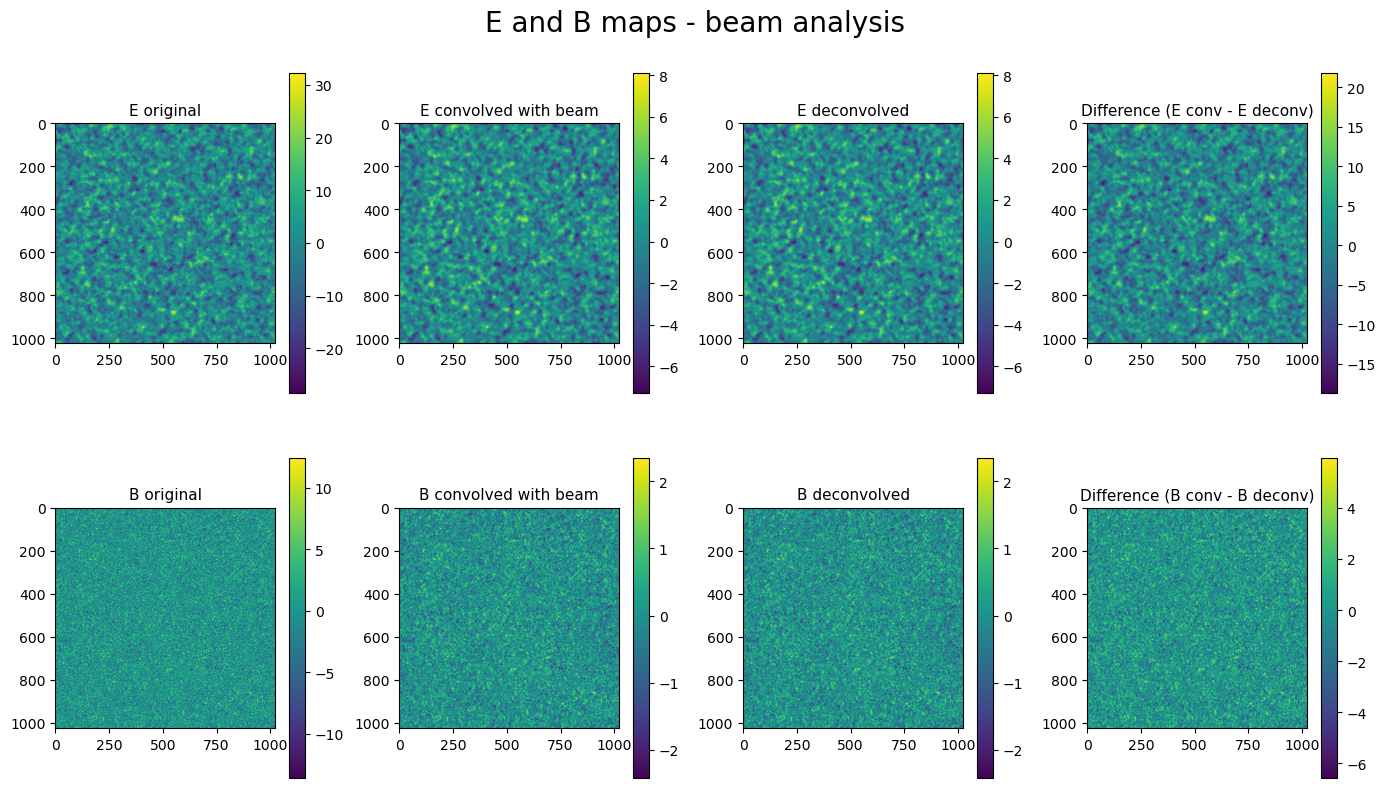

'\nmap_list      = [E_conv, E_deconv, E_diff, B_conv, B_deconv, B_diff] \ntitle_list    = ["E map original", "E after con-deconv", "E difference", "B map original", "B after conv-deconv", "B difference"]\ncolor_rescale = [15, 15, 1e3, 150, 150, 1e4]\n\nfig, axs = plt.subplots(2, 3, figsize=(15, 8))\naxs      = axs.flatten()\n\nfor i, map_data in enumerate(map_list):\n\n        Plot_CMB_Map_compact(axs[i], map_data, c_min/color_rescale[i], c_max/color_rescale[i], X_width, Y_width)\n        axs[i].set_title(title_list[i])\n        \n        \nplt.tight_layout()\nplt.subplots_adjust(wspace=0, hspace=0.5, top=0.90)\nplt.suptitle(\'E and B maps- before and after conv-deconv\', fontsize=16)\nplt.savefig(\'/Users/guide/Documents/University/TESI/immagini/EB_ConvDeconv.png\')\nplt.show()\n'

In [20]:
Map_to_Plot = [E_map, E_conv, E_deconv, E_diff, 
               B_map, B_conv, B_deconv, B_diff]
title = ["E original", "E convolved with beam", "E deconvolved", "Difference (E conv - E deconv)", 
         "B original", "B convolved with beam", "B deconvolved", "Difference (B conv - B deconv)"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4]), np.max(Map_to_Plot[5]), np.max(Map_to_Plot[6]), np.max(Map_to_Plot[7])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4]), np.min(Map_to_Plot[5]), np.min(Map_to_Plot[6]), np.min(Map_to_Plot[7])]


fig, axs = plt.subplots(2, 4, figsize=(14, 8))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
    im = axs[i].imshow(map_data, vmin=c_factor_iter_min, vmax=c_factor_iter_max)
    axs[i].set_title(title[i], fontsize = 11)
    plt.colorbar(im, ax=axs[i], orientation='vertical')
    
#fig.delaxes(axs[-1])
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle(f'E and B maps - beam analysis', fontsize=20)
plt.show()



'''
map_list      = [E_conv, E_deconv, E_diff, B_conv, B_deconv, B_diff] 
title_list    = ["E map original", "E after con-deconv", "E difference", "B map original", "B after conv-deconv", "B difference"]
color_rescale = [15, 15, 1e3, 150, 150, 1e4]

fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs      = axs.flatten()

for i, map_data in enumerate(map_list):

        Plot_CMB_Map_compact(axs[i], map_data, c_min/color_rescale[i], c_max/color_rescale[i], X_width, Y_width)
        axs[i].set_title(title_list[i])
        
        
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.5, top=0.90)
plt.suptitle('E and B maps- before and after conv-deconv', fontsize=16)
plt.savefig('/Users/guide/Documents/University/TESI/immagini/EB_ConvDeconv.png')
plt.show()
'''

### PS

In [21]:
delta_l = 50.
l_max   = 2500

# Power spectra deconvolved maps
binned_l_E_deconv, binned_spectrum_E_deconv = calculate_2d_spectrum(E_deconv,E_deconv,delta_l,l_max,pix_size,N)
binned_l_B_deconv, binned_spectrum_B_deconv = calculate_2d_spectrum(B_deconv,B_deconv,delta_l,l_max,pix_size,N)

# Power spectra difference maps - to obtain the side lobes
binned_l_Ediff, binned_spectrum_Ediff = calculate_2d_spectrum(E_diff,E_diff,delta_l,l_max,pix_size,N)
binned_l_Bdiff, binned_spectrum_Bdiff = calculate_2d_spectrum(B_diff,B_diff,delta_l,l_max,pix_size,N)

# Power spectra of maps convolved with a perfect beam to compare better with the deconvolved power spectra
binned_l_E_conv, binned_spectrum_E_conv = calculate_2d_spectrum(E_conv,E_conv,delta_l,l_max,pix_size,N)
binned_l_B_conv, binned_spectrum_B_conv = calculate_2d_spectrum(B_conv,B_conv,delta_l,l_max,pix_size,N)

In [22]:

# ci mette un po' (un paio di minuti)

beam_size_fwhp    = 1.25
white_noise_level = 0.5
atmospheric_noise_level = 0.1 * 0 #azzerato
one_over_f_noise_level  = 0.2 * 0 #azzerato

# TRANSFER FUNCTION - multiplicative bias
N_iterations  = 16
signal_only_E_deconv = np.zeros([N_iterations,int(l_max/delta_l)])
signal_only_B_deconv = np.zeros([N_iterations,int(l_max/delta_l)])
signal_only_Ediff = np.zeros([N_iterations,int(l_max/delta_l)])
signal_only_Bdiff = np.zeros([N_iterations,int(l_max/delta_l)])

i = 0

while (i < N_iterations):
         
    map_convolved_E_deconv = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,E_deconv)
    map_convolved_B_deconv = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,B_deconv)
    map_convolved_Ediff = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,E_diff)
    map_convolved_Bdiff = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,B_diff)
    
    binned_l_cur_E_deconv, binned_spectrum_cur_E_deconv = calculate_2d_spectrum(map_convolved_E_deconv*window, map_convolved_E_deconv*window,delta_l,l_max,pix_size,N)
    binned_l_cur_B_deconv, binned_spectrum_cur_B_deconv = calculate_2d_spectrum(map_convolved_B_deconv*window, map_convolved_B_deconv*window,delta_l,l_max,pix_size,N)
    binned_l_cur_Ediff, binned_spectrum_cur_Ediff = calculate_2d_spectrum(map_convolved_Ediff*window, map_convolved_Ediff*window,delta_l,l_max,pix_size,N)
    binned_l_cur_Bdiff, binned_spectrum_cur_Bdiff = calculate_2d_spectrum(map_convolved_Bdiff*window, map_convolved_Bdiff*window,delta_l,l_max,pix_size,N)
    
    
    signal_only_E_deconv[i,:] = binned_spectrum_cur_E_deconv
    sys.stdout.flush()
    signal_only_B_deconv[i,:] = binned_spectrum_cur_B_deconv
    sys.stdout.flush()
    signal_only_Ediff[i,:] = binned_spectrum_cur_Ediff
    sys.stdout.flush()
    signal_only_Bdiff[i,:] = binned_spectrum_cur_Bdiff
    sys.stdout.flush()
    i = i + 1
    
sig_only_mean_spectrum_E_deconv, rms_E_deconv = average_N_spectra(signal_only_E_deconv,N_iterations,int(l_max/delta_l))
sig_only_mean_spectrum_B_deconv, rms_B_deconv = average_N_spectra(signal_only_B_deconv,N_iterations,int(l_max/delta_l))
sig_only_mean_spectrum_Ediff, rms_Ediff = average_N_spectra(signal_only_Ediff,N_iterations,int(l_max/delta_l))
sig_only_mean_spectrum_Bdiff, rms_Bdiff = average_N_spectra(signal_only_Bdiff,N_iterations,int(l_max/delta_l))


sub_sampled_CLs_E_deconv = EE_ps[binned_l_E_deconv] * 2. * np.pi / (binned_l_E_deconv * (binned_l_E_deconv+1.))
sub_sampled_CLs_B_deconv = BB_ps[binned_l_B_deconv] * 2. * np.pi / (binned_l_B_deconv * (binned_l_B_deconv+1.))

# NON HO IL SUB SAMPLE PER Q E U DIFF

Multiplicative_Bias_est_E_deconv =  sub_sampled_CLs_E_deconv / sig_only_mean_spectrum_E_deconv
Multiplicative_Bias_est_B_deconv =  sub_sampled_CLs_B_deconv / sig_only_mean_spectrum_B_deconv



# NOISE - noise bias
noise_only = np.zeros([N_iterations,int(l_max/delta_l)])
i = 0

while (i <N_iterations):
    Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)
    binned_l_cur, binned_spectrum_cur = calculate_2d_spectrum(Noise*window,Noise*window,delta_l,l_max,pix_size,N)
    
    noise_only[i,:] = binned_spectrum_cur
    sys.stdout.flush()
    i = i + 1

noise_only_mean_spectrum, rms_not_needed = average_N_spectra(noise_only,N_iterations,int(l_max/delta_l))
Additive_Bias_est = noise_only_mean_spectrum


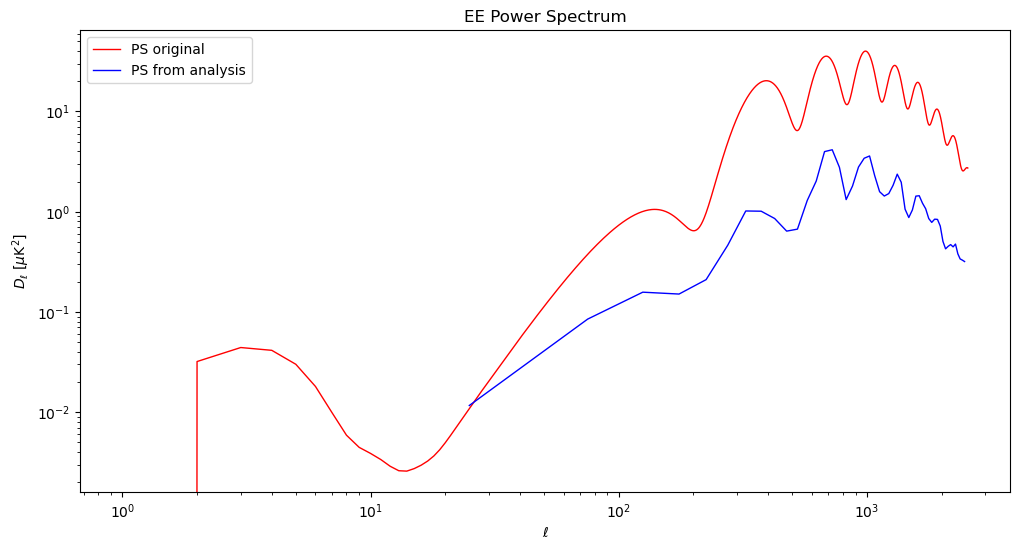

In [23]:
# EE
# devo confrontare quello ottenuto dall'analisi con quello originale o quello "originale" ma di una mappa convoluta con il beam perfetto?
plt.figure(figsize=(12, 6))

# PS originale da camb
plt.loglog(ls,EE_ps, label="PS original", c="r", linewidth=1)

# PS dalle mappe convolute - deconvolute con beam con sistematiche
plt.loglog(binned_l_E_deconv, binned_spectrum_E_deconv* binned_l_E_deconv * (binned_l_E_deconv+1.)/2. / np.pi,color='b', linewidth =1,label="PS from analysis")

# PS da mappe quasi originali, perchè convolute con un beam perfetto
#plt.semilogy(binned_l_E_conv, binned_spectrum_E_conv* binned_l_E_conv * (binned_l_E_conv+1.)/2. / np.pi,color='black', label="PS original, convolved")



plt.title("EE Power Spectrum")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.show()
# i due spettri che si sovrappongono sono molto simili ma non uguali

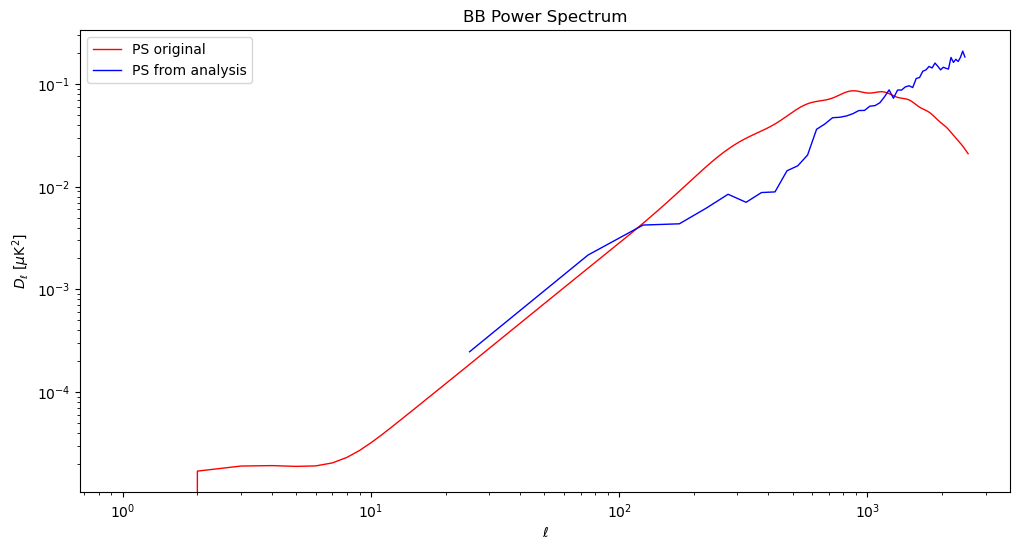

In [24]:
# BB
plt.figure(figsize=(12, 6))

# PS originale da camb
plt.loglog(ls,BB_ps, label="PS original", c="r", linewidth=1)

# PS dalle mappe convolute - deconvolute con beam con sistematiche
plt.loglog(binned_l_B_deconv, binned_spectrum_B_deconv* binned_l_B_deconv * (binned_l_B_deconv+1.)/2. / np.pi,color='b',  linewidth =1,label="PS from analysis")

# PS da mappe quasi originali, perchè convolute con un beam perfetto
#plt.semilogy(binned_l_B_conv, binned_spectrum_B_conv* binned_l_B_conv * (binned_l_B_conv+1.)/2. / np.pi,color='black', label="PS original, convolved")



plt.title("BB Power Spectrum")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/BeamBPS.png')
plt.show()

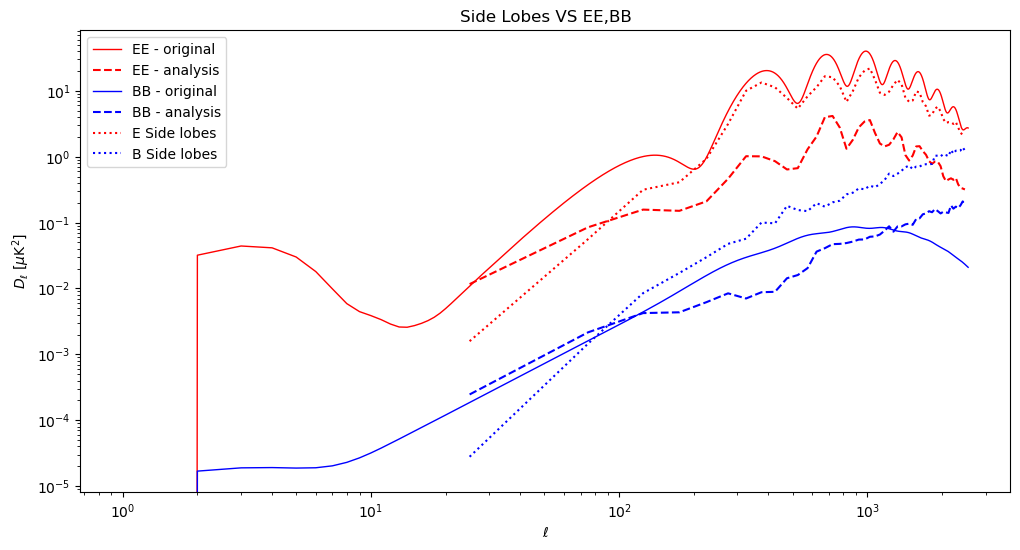

In [25]:
plt.figure(figsize=(12, 6))

# EE
plt.loglog(ls, EE_ps, label="EE - original", c="r", linewidth=1)
plt.loglog(binned_l_E_deconv, binned_spectrum_E_deconv* binned_l_E_deconv * (binned_l_E_deconv+1.)/2. / np.pi,color='r', linestyle="--",label="EE - analysis")

#BB
plt.loglog(ls, BB_ps, label="BB - original", c="b", linewidth=1)
plt.loglog(binned_l_B_deconv, binned_spectrum_B_deconv* binned_l_B_deconv * (binned_l_B_deconv+1.)/2. / np.pi,color='b', linestyle="--", label="BB - analysis")

# SIDE LOBES
plt.loglog(binned_l_Ediff, binned_spectrum_Ediff* binned_l_Ediff * (binned_l_Ediff+1.)/2. / np.pi,color='red', linestyle=":", label="E Side lobes")
plt.loglog(binned_l_Bdiff, binned_spectrum_Bdiff* binned_l_Bdiff * (binned_l_Bdiff+1.)/2. / np.pi,color='blue', linestyle=":", label="B Side lobes")


plt.title("Side Lobes VS EE,BB")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/BeamLobesPS.png')
plt.show()

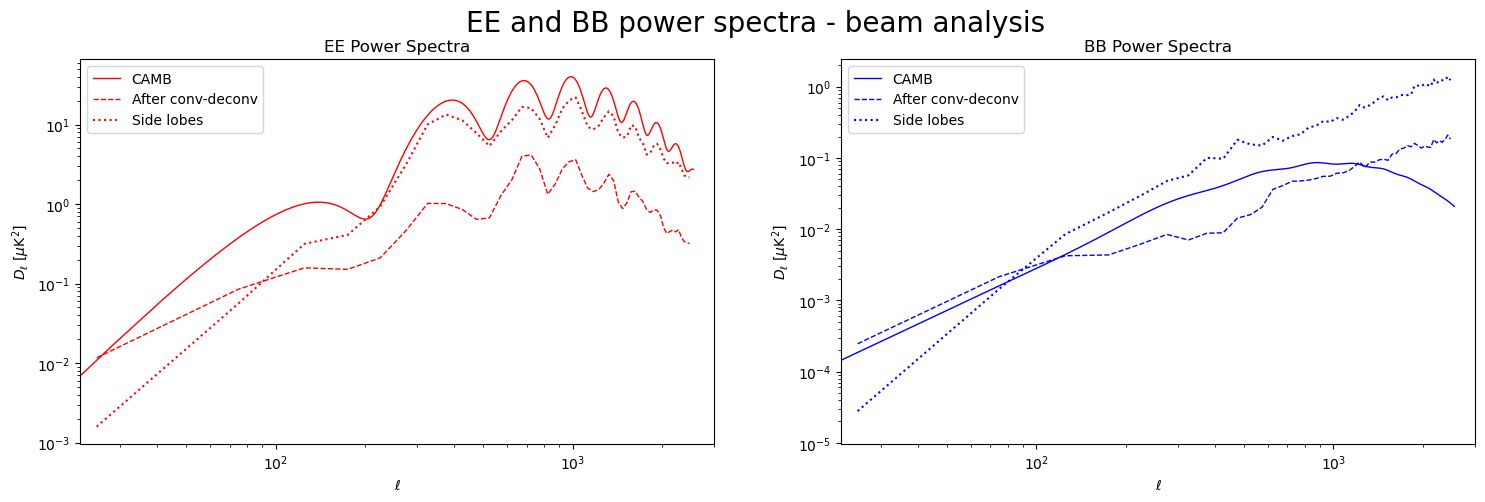

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Primo subplot - EE Power Spectrum
axs[0].loglog(ls, EE_ps, label="CAMB", c="r", linewidth=1)
axs[0].loglog(binned_l_E_deconv, binned_spectrum_E_deconv * binned_l_E_deconv * (binned_l_E_deconv + 1.) / 2. / np.pi,
                c="r", linewidth=1, label="After conv-deconv", linestyle="--")
axs[0].loglog(binned_l_Ediff, binned_spectrum_Ediff* binned_l_Ediff * (binned_l_Ediff+1.)/2. / np.pi, c="r", linestyle=":", label="Side lobes")

axs[0].set_title("EE Power Spectra")
axs[0].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]')
axs[0].set_xlabel('$\ell$')
axs[0].legend()
axs[0].set_xlim(22,3000)

# Secondo subplot - BB Power Spectrum
axs[1].loglog(ls, BB_ps, label="CAMB", c="b", linewidth=1)
axs[1].loglog(binned_l_B_deconv, binned_spectrum_B_deconv * binned_l_B_deconv * (binned_l_B_deconv + 1.) / 2. / np.pi,
                c="b", linewidth=1, label="After conv-deconv", linestyle="--")
axs[1].loglog(binned_l_Bdiff, binned_spectrum_Bdiff* binned_l_Bdiff * (binned_l_Bdiff+1.)/2. / np.pi, c="b", linestyle=":", label="Side lobes")

axs[1].set_title("BB Power Spectrum")
axs[1].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]')
axs[1].set_xlabel('$\ell$')
axs[1].legend()
axs[1].set_xlim(22,3000)

plt.xlim(22,3000)
plt.title("BB Power Spectra")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.suptitle('EE and BB power spectra - beam analysis', fontsize = 20)
plt.legend()
plt.show()